<a href="https://colab.research.google.com/github/Khaled-844AI/01_pytorch_worckflow_video/blob/main/CarsClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
import tensorflow as tf
import os
import tensorflow_probability as tfp
from google.colab import drive
from tensorflow.keras.layers import Input , Layer, Dense, GlobalAveragePooling2D, BatchNormalization ,Resizing,Rescaling,Conv2D,MaxPooling2D,Flatten,RandomRotation, RandomFlip, RandomContrast
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import pathlib
from pathlib import Path
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import imghdr
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
import numpy as np

In [8]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
folder_path = '/content/drive/My Drive/Colab Notebooks/Cars'
files = os.listdir(folder_path)
files

['modern Cars', 'cheap Cars', 'old Cars']

In [11]:
!mkdir /content/data

In [39]:
!cp -r '/content/drive/My Drive/Colab Notebooks/Cars' '/content/data'


In [13]:
!mkdir /content/data/Cars/train
!mkdir /content/data/Cars/test
!mkdir /content/data/Cars/val

In [14]:
!mkdir '/content/data/Cars/train/cheap Cars'
!mkdir '/content/data/Cars/train/modern Cars'
!mkdir '/content/data/Cars/train/old Cars'

!mkdir '/content/data/Cars/test/cheap Cars'
!mkdir '/content/data/Cars/test/modern Cars'
!mkdir '/content/data/Cars/test/old Cars'

!mkdir '/content/data/Cars/val/cheap Cars'
!mkdir '/content/data/Cars/val/modern Cars'
!mkdir '/content/data/Cars/val/old Cars'


In [15]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu , True)

In [45]:
img = cv2.imread(os.path.join('/content/data/Cars/train' , 'modern Cars' , '2022-Ford-Mustang-Shelby-GT500_01-1024x576.jpg'))
img.shape

(576, 1024, 3)

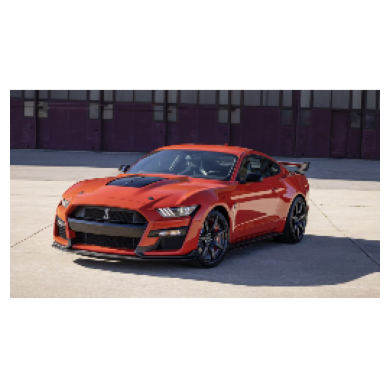

In [51]:
img_resized = cv2.resize(img, (256, 256))
plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))

In [18]:
train_directory = '/content/data/train'
val_directory = '/content/data/val'
test_directory = '/content/data/test'

In [19]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

folder_path = '/content/data/Cars'
classes = ['cheap Cars', 'modern Cars', 'old Cars']  # Your class names
train_dir = os.path.join(folder_path, 'train')
val_dir = os.path.join(folder_path, 'val')
test_dir = os.path.join(folder_path, 'test')

for cls in classes:
    cls_path = os.path.join(folder_path, cls)
    files = os.listdir(cls_path)

    # Shuffle the files
    np.random.shuffle(files)

    # Calculate split indices
    total_files = len(files)
    train_end = int(total_files * 0.7)
    val_end = train_end + int(total_files * 0.15)

    # Split files
    train_files = files[:train_end]
    val_files = files[train_end:val_end]
    test_files = files[val_end:]

    # Move files to the respective directories
    for f in train_files:
        shutil.move(os.path.join(cls_path, f), os.path.join(train_dir, cls, f))
    for f in val_files:
        shutil.move(os.path.join(cls_path, f), os.path.join(val_dir, cls, f))
    for f in test_files:
        shutil.move(os.path.join(cls_path, f), os.path.join(test_dir, cls, f))

print("Dataset has been split into train, val, and test sets.")



Dataset has been split into train, val, and test sets.


In [20]:
train_directory = '/content/data/Cars/train'
val_directory = '/content/data/Cars/val'
test_directory = '/content/data/Cars/test'

In [21]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=['cheap Cars','modern Cars', 'old Cars'],
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99,
)

Found 1083 files belonging to 3 classes.


In [22]:
val_data = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=['cheap Cars','modern Cars', 'old Cars'],
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99,
)

Found 231 files belonging to 3 classes.


In [23]:
test_data = tf.keras.utils.image_dataset_from_directory(
    test_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=['cheap Cars','modern Cars', 'old Cars'],
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99,
)

Found 235 files belonging to 3 classes.


In [78]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (-0.025 , 0.025)),
    RandomFlip(mode = 'horizontal'),
    RandomContrast(factor = 0.1)
])

In [53]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(256 , 256),
    Rescaling(1./255)
])

In [79]:
def augment_layer(image , label):
  return augment_layers(image , training = True), label

In [82]:
def box(lamda):

    r_x = tf.cast(tfp.distributions.Uniform(0 , 256).sample(1)[0] , dtype = tf.int32)
    r_y = tf.cast(tfp.distributions.Uniform(0 , 256).sample(1)[0] , dtype = tf.int32)

    r_w = tf.cast(256*tf.math.sqrt(1 - lamda) , dtype = tf.int32)
    r_h = tf.cast(256*tf.math.sqrt(1 - lamda) , dtype = tf.int32)

    r_x = tf.clip_by_value( r_x - r_w//2 ,0 , 256)
    r_y = tf.clip_by_value( r_y - r_h//2 ,0 , 256)

    x_b_r = tf.clip_by_value( r_x + r_w//2 ,0 , 256)
    y_b_r = tf.clip_by_value( r_y + r_h//2 ,0 , 256)

    r_w = x_b_r - r_x
    if r_w == 0:
        r_w = 1

    r_h = y_b_r - r_y
    if r_h == 0:
        r_h = 1

    return r_y , r_x , r_h , r_w

In [84]:
def cutmix(train_dataset1 , train_dataset2):
  (image_1 , label1) , (image_2 , label2) = train_dataset1 , train_dataset2

  lamda = tfp.distributions.Beta(0.2 , 0.2).sample(1)[0]


  r_y , r_x , r_h , r_w = box(lamda)

  crop2 = tf.image.crop_to_bounding_box(image_2 , r_y , r_x , r_h , r_w)
  pad2 = tf.image.pad_to_bounding_box(crop2 , r_y , r_x , 256 , 256)

  crop1 = tf.image.crop_to_bounding_box(image_1 , r_y , r_x , r_h , r_w)
  pad1 = tf.image.pad_to_bounding_box(crop1 , r_y , r_x , 256 ,256)

  image = image_1 - pad1 + pad2

  lamda = tf.cast(1 - (r_h * r_w)/(256 * 256) , dtype = tf.float32)

  label = lamda * tf.cast(label1, dtype = tf.float32) + (1 - lamda) * tf.cast(label2, dtype = tf.float32)

  return image , label

In [85]:
train_dataset1 = train_data.map(augment_layer , num_parallel_calls = tf.data.AUTOTUNE)
train_dataset2 = train_data.map(augment_layer , num_parallel_calls = tf.data.AUTOTUNE)

mix_data = tf.data.Dataset.zip((train_dataset1 , train_dataset2))

In [86]:
trainning_data = mix_data.map(cutmix , num_parallel_calls = tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
validation_data = val_data.prefetch(tf.data.AUTOTUNE)

In [95]:
backbone = tf.keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(256, 256, 3)
)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [96]:
backbone.trainable = False

In [97]:
model = tf.keras.Sequential([
    Input(shape=(256 , 256 , 3)),
    resize_rescale_layers,
    backbone,
    GlobalAveragePooling2D(),
    Dense(100, 'relu'),
    BatchNormalization(),
    Dense(10, 'relu'),
    Dense(3, 'softmax'),
])

In [98]:
checkpoint = ModelCheckpoint(
    'best_weights.keras',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

In [99]:
loss_function = CategoricalCrossentropy()

In [100]:
metrics = [CategoricalAccuracy(name = 'accuracy') , TopKCategoricalAccuracy(k = 2, name = 'top_k_accuracy')]

In [101]:
lr = 0.001
model.compile(
    optimizer = Adam(lr),
    loss=loss_function,
    metrics=metrics
)

In [102]:
history = model.fit(
    trainning_data,
    epochs = 60,
    validation_data = validation_data,
    verbose = 1,
    callbacks = [checkpoint]
    )

Epoch 1/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5088 - loss: 1.0939 - top_k_accuracy: 0.8205   
Epoch 1: val_accuracy improved from -inf to 0.61905, saving model to best_weights.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.5104 - loss: 1.0912 - top_k_accuracy: 0.8214 - val_accuracy: 0.6190 - val_loss: 0.9852 - val_top_k_accuracy: 0.9048
Epoch 2/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.7247 - loss: 0.7539 - top_k_accuracy: 0.9253
Epoch 2: val_accuracy improved from 0.61905 to 0.71861, saving model to best_weights.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7254 - loss: 0.7531 - top_k_accuracy: 0.9254 - val_accuracy: 0.7186 - val_loss: 0.9167 - val_top_k_accuracy: 0.8874
Epoch 3/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 985ms/step - accuracy: 0.8339 - loss: 0.5642 - top_k_accuracy: 0.9576
Epoch 3: val_accuracy did not improve from 0.71861
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8332 - loss: 0.5657 - top_k_accuracy: 0.9574 -

In [104]:
model.save('Carsmodel.keras')

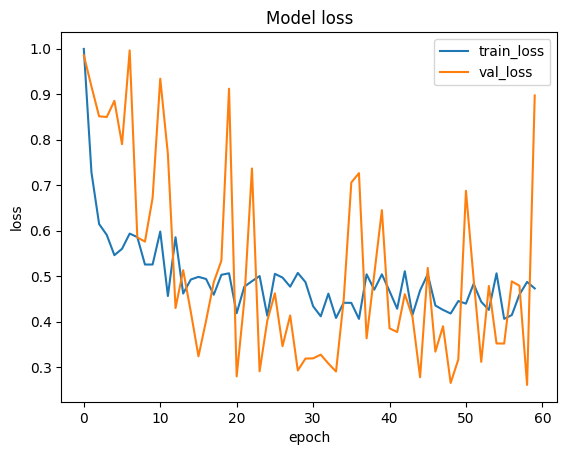

In [105]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [108]:
model.load_weights('best_weights.keras')
model.evaluate(test_data)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 288ms/step - accuracy: 0.8672 - loss: 0.3399 - top_k_accuracy: 0.9731


[0.36468610167503357, 0.8638297915458679, 0.9744681119918823]

In [118]:
img = cv2.imread('/content/cady.jpg')
img.shape

(1280, 720, 3)

In [119]:
img_resized = cv2.resize(img, (256, 256))

img_resized = np.expand_dims(img_resized, axis=0)

predictions = model.predict(img_resized)

print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[0.4888757  0.28255722 0.22856711]]
